# Evolution of Disk and Bulge S&eacute;rsic Profiles During the MW-M31 Major Merger

My research project involves examing how the S&eacute;rsic profiles/S&eacute;rsic indices of the bulges and disks of the Milky Way and Andromeda (M31) galaxies evolve throughout their simulated future merger. This will be executed by fitting S&eacute;rsic profiles to snapshots of the radial intensity profile for each galaxy's bulge and disk.

**Imports and Preferences:**

In [74]:
# Load Modules
import numpy as np
import astropy.units as u

# import plotting modules
import smplotlib
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt

# # font preferences
mpl.rcParams.update({
    'xtick.major.width': 1,
    'ytick.major.width': 1,
    'xtick.minor.width': 1,
    'ytick.minor.width': 1,
    'lines.markeredgewidth': 1,
    'axes.linewidth': 1,
    'path.simplify': True,
    'legend.numpoints': 1,
    'legend.handletextpad': 0.3
})

# high quality figures
plt.rcParams['savefig.dpi'] = 600

# my modules
from ReadFile import Read
from CenterOfMass import CenterOfMass
from MassProfile import MassProfile
from GalaxyMass import ComponentMass

# garbage collection
import gc

# fitting
from scipy.optimize import curve_fit

# S&eacute;rsic Profiles

# ADD CITATIONS FOR THESE EQUATIONS

Used here to describe intensity (power per unit area) as a function of cylindrical radius for galaxies.

## ``sersic`` Function: 

We have a function called `sersic` that returns the S&eacute;rsic Profile in terms of the effective radius $R_\mathrm{e}$ (i.e. the half light radius).

$$\large I(r) = I_\mathrm{e} e^{-7.67 \left[ (r/R_\mathrm{e})^{1/n} - 1\right]} $$

Where 

$$\large L = 7.2\pi I_\mathrm{e} R_\mathrm{e}^2 $$

We will assume a mass to light ratio for disk and bulge particles of 1, so **this is also the half mass radius**, and so $\Sigma$, the projected area mass density, is nominally equivalent to the intensity $I$.

The function takes as input the radius, $R_e$, $n$ (S&eacute;rsic index) and the total stellar mass $M_\mathrm{tot}$ of the system.

In [2]:
def sersic(r, R_e, n, M_tot):
    """ Function that computes a Sersic Profile assuming M/L = 1.
    
    PARMETERS
    ---------
        r : `float`
            Distance from the center of the galaxy (kpc)
            
        R_e : `float`
            Effective radius (2D radius that contains 
            half the light) (kpc)
            
        n :  `float`
            Sersic index
            
        M_tot : `float`
            Total stellar mass (Msun)

    RETURNS
    -------
        I: `array of floats`
            the radial intensity profile of the galaxy in Lsun/kpc^2

    """

    # We are assuming M/L = 1, so the total luminosity is:
    lum = M_tot
    
    # the effective intensity is
    I_e = lum / 7.2 / np.pi / R_e**2
    
    # Break down the equation 
    a = (r / R_e)**(1.0/n)
    b = -7.67 * (a-1)
    
    # Intensity
    #I = Ie*np.exp(-7.67*((r/R_e)**(1.0/n)-1.0))
    I = I_e * np.exp(b)
    
    del lum, I_e, a, b
    gc.collect()
    
    return I

## ``disk`` Function:

This fits a profile that better describes an exponential disk,

$$\Large I = I_0 e^{-r/h_r}$$

As above with the S&eacute;rsic profiles, we assume a mass-to-light ratio of 1. $I_0$ is an effective intensity, where:

$$\Large I_0 = \frac{I}{2\pi h_r^2}$$

In [3]:
def disk(r, hr, M_tot):
    """ Function that computes an exponential disk Profile assuming M/L = 1.
    
    PARMETERS
    ---------
        r : `float`
            Distance from the center of the galaxy (kpc)
            
        hr : `float`
            Disk scale length (kpc)
            
        M_tot : `float`
            Total stellar mass (Msun)

    RETURNS
    -------
        I: `array of floats`
            the radial intensity profile of the galaxy in Lsun/kpc^2

    """
    
    # We are assuming M/L = 1, so the total luminosity is:
    lum = M_tot

    # the effective surface brightness is
    # L = piIohr^2(2!)
    Io = lum/np.pi/hr**2/2
    
    # The surface brightness
    I = Io*np.exp(-r/hr)
    
    del Io
    gc.collect()
    
    return I

## ``RadialIntensity`` Class:

In [67]:
class RadialIntensity:
    """Creates an object that can compute and plot a radial intensity profile
    for a galaxy."""

    
    def __init__(self, galaxy, snap, res, comp, r_num, fit_op):
        """
        Initializes a RadialIntensity object, selecting the right data for the 
        given resolution (res), component (comp), and snapshot (snap) for galaxy
        galaxy. Plot colors, limits, and annotations are set based on the selections
        made for galaxy and comp. The filename to read in, the total mass of the
        given galaxy component, and the number of radii to convert into annuli are
        stored.
        
        Inputs:
            
            galaxy : `string`
                Name of the galaxy to create an intensity profile for ('MW' or 'M31')
                (case-sensitive)
                
            snap : `int`
                Snapshot (0–801) to read in.
                
            res : `string`
                'high' or 'low' simulation resolution (case-sensitive)
                
            comp : `string`
                Galaxy component, 'Disk' or 'Bulge' (case-sensitive)
                
            r_num : `int`
                numbr of radii to turn into annuli inner and outer radii for computing
                intensities within.
                
            fit_op : `string`
                "sersic" or "disk" to choose which profile can be fit to the data.
                
        Returns:
        
            None
        """
        
        # Select the desired simulation resolution
        if res == 'high':
            snap_path = 'HighRes_' + galaxy + '/'
        elif res == 'low':
            snap_path = 'VLowRes_' + galaxy + '/'
        
        # Component options
        if comp == 'Disk':
            self.p_type = 2 # particle type for disk particles
            
            # Differentiate colors by component _and_ galaxy
            if galaxy == 'MW':
                self.color = '#0000FF'
            else:
                self.color = '#FF0000'
    
        elif comp == 'Bulge':
            self.p_type = 3 # particle type for bulge particles
            
            # Differentiate colors by component _and_ galaxy
            if galaxy == 'MW':
                self.color = '#FF00FF'
            else:
                self.color='#00FF00'
            
        # store the component string for later use when plotting
        self.comp = comp
        
        # store the fitting choice
        self.fit_op = fit_op
        
        # add a string of the filenumber to the value “000”
        snap_str= '000' + str(snap)
        # remove all but the last 3 digits
        snap_str = snap_str[-3:]
        
        # Store the snap_str for later use when writing plots to PNGs
        self.snap_str = snap_str

        # construct filename for later use
        data_path = '/Users/gabeweible/Desktop/Data/'
        self.filename = data_path + snap_path + galaxy + '_' + snap_str + '.txt'
        
        # Store the galaxy for later use when plotting
        self.galaxy = galaxy
        # store the snap to compute the time in Gyr later
        self.snap = snap
        # store the number of radii for later annuli generation
        self.r_num = r_num
        
        # Store the total mass for the given component for creating a Sersic profile
        self.m_tot = ComponentMass(self.filename, self.p_type) * 1e12 # Msun
         
        # Create a center of mass object for the disk particles to get the COM
        # This lets us get the x, y, z relative to the COM
        COM_disk = CenterOfMass(self.filename, 2)
        
        # Load in a CenterOfMass object for the particle type we want to analyze
        COM = CenterOfMass(self.filename, self.p_type)
        self.COM = COM
        
        COM_p = COM_disk.COM_P(0.1) # COM position
        COM_v = COM_disk.COM_V(*COM_p)
        
        # Save COM position and velocity
        self.COM_p = COM_p
        self.COM_v = COM_v
        
        # save disk COM object
        self.COM_disk = COM_disk
        
        del COM_p, COM_v, COM, r_num, snap, galaxy, data_path, snap_path, snap_str,
        comp
        gc.collect()
        
    
    def RotateFrame(self):
        """a function that will rotate the position and velocity vectors
        so that the disk angular momentum is aligned with z axis. 

        PARAMETERS
        ----------
            None

        RETURNS
        -------
            pos: `array of floats`
                rotated 3D array of positions (x,y,z) such that disk is in the XY plane
            vel: `array of floats`
                rotated 3D array of velocities (vx,vy,vz) such that disk angular momentum vector
                is in the +z direction 
        """
        
        # Compute COM using disk particles
        COMP = self.COM_p
        COMV = self.COM_v
        
        # Determine positions of disk particles relative to COM 
        xD = self.COM_disk.x - COMP[0].value 
        yD = self.COM_disk.y - COMP[1].value 
        zD = self.COM_disk.z - COMP[2].value 

        # total magnitude
        rtot = np.sqrt(xD**2 + yD**2 + zD**2)

        # Determine velocities of disk particles relative to COM motion
        vxD = self.COM_disk.vx - COMV[0].value 
        vyD = self.COM_disk.vy - COMV[1].value 
        vzD = self.COM_disk.vz - COMV[2].value 

        # total velocity 
        vtot = np.sqrt(vxD**2 + vyD**2 + vzD**2)

        # Vectors for r and v 
        r = np.array([xD,yD,zD]).T # transposed 
        v = np.array([vxD,vyD,vzD]).T

        # compute the angular momentum
        L = np.sum(np.cross(r, v), axis=0)
        # normalize the vector
        L_norm = L/np.sqrt(np.sum(L**2))


        # Set up rotation matrix to map L_norm to z unit vector (disk in xy-plane)

        # z unit vector
        z_norm = np.array([0, 0, 1])

        # cross product between L and z
        vv = np.cross(L_norm, z_norm)
        s = np.sqrt(np.sum(vv**2))

        # dot product between L and z 
        c = np.dot(L_norm, z_norm)

        # rotation matrix
        I = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
        v_x = np.array([[0, -vv[2], vv[1]], [vv[2], 0, -vv[0]], [-vv[1], vv[0], 0]])
        R = I + v_x + np.dot(v_x, v_x)*(1 - c)/s**2
        
        # R will let us rotate any position or velocity into the Disk-rotated frame
        del I, v_x, s, c, vv, L_norm, z_norm, L, r, v, xD, yD, zD, vxD, vyD, vzD,
        vtot, rtot, COMP, COMV
        
        gc.collect()
        
        return R


    def profile(self):
        """
        Calculates a radial area mass density profile using annuli in cylindrical
        coordinates.
        
        Inputs: 
        
            None
            
        Returns: 
            
            (r_annuli, I, R_e) : `tuple`
                Tuple of the annuli that area mass densities are calculated within,
                r_annuli, the intensity profile, I, and the effective
                (half-light / half-mass) radius, R_e. These are used for plotting.
        """
        
        # Get a vector to help us rotate
        R = self.RotateFrame()
        
        # selected particle positions and velocities wrt COM
        x_i = self.COM.x - self.COM_p[0].value
        y_i = self.COM.y - self.COM_p[1].value
        z_i = self.COM.z - self.COM_p[2].value
        m = self.COM.m
        
        # transposed to work with rotation
        r_i = np.array([x_i, y_i, z_i]).T
        
        # Rotated positions (not in COM frame)
        rr = np.dot(R, r_i.T).T
        
        # Extract components and use as before
        x = rr[:,0]
        y = rr[:,1]
        z = rr[:,2]

        # calculate the radial distances of particles in cylindrical coordinates
        cyl_r_mag = np.sqrt(x**2 + y**2)

        # create a logspace (base 2) array of radii so that annuli radii increase
        # as we move out into the more sparse outer regions
        radii = np.logspace(np.log2(1), np.log2(40),
                            num=self.r_num, base=2) # kpc

        # create the mask to select particles enclosed for each radius
        # np.newaxis creates a virtual axis to make tmp_r_mag 2 dimensional
        # so that all radii can be compared simultaneously
        enc_mask = cyl_r_mag[:, np.newaxis] < np.asarray(radii).flatten()

        # calculate the enclosed masses 
        # relevant particles will be selected by enc_mask (i.e., *1)
        # outer particles will be ignored (i.e., *0)
        m_enc = np.sum(m[:, np.newaxis] * enc_mask, axis=0) * 1e10 # Msun

        # use the difference between nearby elements to get mass in each annulus
        m_annuli = np.diff(m_enc) # one element less then m_enc
        
        # Area mass density
        Sigma = m_annuli / (np.pi * (radii[1:]**2 - radii[:-1]**2))
        
        # convert area mass density to intensity with a mass-to-light ratio (1, here)
        m_to_l = 1
        I = Sigma / m_to_l

        r_annuli = np.sqrt(radii[1:] * radii[:-1])
        # here we choose the geometric mean
        
        half_mass = self.m_tot / 2
        indices = np.where(m_enc > half_mass)
        R_maj = radii[indices]

        # the first such index gives us the index of our half-light radius
        R_e = R_maj[0] # kpc

        # return the stuff that we need to make a plot
        
        del R_maj, indices, radii, m_enc, half_mass, m_to_l, Sigma, enc_mask, cyl_r_mag,
        x, y, z, rr, r_i, m, x_i, y_i, z_i, R
        
        gc.collect()
        
        return (r_annuli, I, R_e)
    
    
    def fit(self, r_annuli, I, R_e, fit_op):
        """
        This method uses scipy.optimize.curve_fit to fit a Sersic or exponential disk
        profile (see the `sersic` and `disk` functions) given radii in r_annuli,
        the intensity profile I, equivalent radius R_e, and total mass M_tot.
        
        Inputs:
            
            r_annuli : `numpy array`
                1D array of float average radius for each annulus.
            
            I : `numpy array`
                1D array of float intensity within each annulus
                
            R_e : `float`
                Effective (half-light / half-mass radius) for the galaxy component
                
            fit_op : `string`
                "sersic" or "disk" to choose which profile is fit to the data.
                
        Returns:
            
            n or hr : `float`
                fitted Sersic index or disk scale length
        """
        
        # Disk
        if fit_op == 'disk':
            
            # use curve_fit to get the best parameter values in popt
            # Here we use a lambda function to only fit for hr
            popt, pcov = curve_fit(lambda r_annuli, hr: disk(r_annuli, hr, self.m_tot), r_annuli, I)

            # Disk scale length
            hr = popt[0] # change 1-element array to just a float

            del popt, pcov
            gc.collect()

            return hr
            
        elif fit_op == 'sersic':

            # use curve_fit to get the best parameter values in popt
            # Here we use a lambda function to only fit for n, not R_e and M_tot
            popt, pcov = curve_fit(lambda r_annuli, n: sersic(r_annuli, R_e, n,
                                                              self.m_tot), r_annuli, I)

            # Sersic index
            n = popt[0] # change 1-element array to just a float

            del popt, pcov
            gc.collect()

            return n
    
    
    def plot_profile(self, r_annuli, I, R_e):
        """
        Uses Matplotlib to create PNGs of radial intensity profiles compared with 
        a de Vaucouleurs (Sersic index n = 4) profile.
        
        Inputs:
            
            r_annuli : `numpy array`
                1D array of float average radius for each annulus
            
            I : `numpy array`
                1D array of float intensity within each annulus
                
            R_e : `float`
                Effective (half-light / half-mass radius) for the galaxy component
                
        Returns:
            
            n : 'float'
                Fitted Sersic index
        """
        
        # Set up big plot
        fig = plt.figure(figsize=(16/2.3, 9/2.3))
        ax = fig.subplots()
        
        # fit the Sersic index n or disk scale length hr as "param"
        param = self.fit(r_annuli, I, R_e, self.fit_op)
        
        # Simulation time
        Gyr = self.snap * 0.01 / 0.7

        # bulge
        if self.fit_op == 'sersic':
        # plot the fitted profile (log-log)
            ax.loglog(r_annuli, sersic(r_annuli, R_e, param, self.m_tot), color='k',
                         linestyle="-.", label=r'Fitted Sérsic $n \! = \! {:.2f}$'.format(param))
            
        elif self.fit_op == 'disk':
            ax.loglog(r_annuli, disk(r_annuli, param, self.m_tot), color='k',
                         linestyle="-.", label=r'Fitted Disk $h_r \! = \! {:.2f} kpc$'.format(param))

        # Plot the calculated intensity profile (log-log)
        ax.loglog(r_annuli, I, alpha=0.8, label='Simulated '+self.comp, lw=2,
                  color=self.color)

        # Set the plot limits to something that works for them all
        ax.set(xlim=(10**(0), 0.4*10**(2)), ylim=(10**2, 10**11))

        # Time annotation
        plt.annotate(r'$\mathrm{{t}} \! = \! {:.2f} \ \mathrm{{Gyr}}$'.format(Gyr),
                 (2, 10**5))
        
        # Axis labels, axis limits, and plot title
        ax.set(xlabel=r'$r \ (\mathrm{kpc})$',
               ylabel=r'$I \ \left(\mathrm{L_\odot} / \mathrm{kpc}^2\right)$',
               title=self.galaxy+' '+ self.comp + ' Particle Radial Intensity Profile')

        # legend and tidy things up
        ax.legend(loc=1, labelcolor='linecolor')
        fig.tight_layout()
        
        # Clear the axes and figure
        plt.cla()
        fig.clf()
        
        # close everything
        plt.close('all')
        plt.close(fig)
        plt.ioff()
        
        # delete variables
        del r_annuli, I, Gyr
        
        # collect garbage
        gc.collect()
        
        return param # Sersic index or disk scale length

## Options!

In [5]:
# options
res = 'low' # resolution of data
r_num = 33 # number of radii to become (r_num - 1) annuli

# Choose which snaps to start and stop at, with what snap step
snap_start = 0 # inclusive
snap_end = 802 # exclusive
snap_step = 1

## Compute intensity profiles and plot

Here we are plotting the calculated intensity profiles for our simulated galaxies as well as fitting S&eacute;rsic profiles by varying the S&eacute;rsic index $n$. The x axis is the radius within the galaxy componnnet and the y axis is the intensity calculated at that radius in cylindrical coordinates. Here the galaxy and component can be chosen above before looping through snapshots starting at ``snap_start``, ending at ``snap_end``, and with a step size of ``snap_step``. The goal of each plot is to show the S&eacute;rsic index at that snapshot, where $n=4$ is like an elliptical galaxy while $n=1$ or $n=2$ would be more characteristic of a disk. This tells us where the stars are radially, in particular how exactly they fall off in density with (cylindrical) radius.

In [6]:
# galaxy and component options as lists
galaxies = ['MW', 'M31']
components = ['Disk', 'Bulge']

# Set up big plot
fig = plt.figure(figsize=(16/2.3, 9/2.3))
ax = fig.subplots()

# Loop through galaxies:
for galaxy in galaxies:
    # loop through components
    for component in components:

        param_list = [] # initialize a list for n or h_r
        # Loop over snapshots (simulation time)
        for snap in range(snap_start, snap_end, snap_step):
            
            # add a string of the filenumber to the value “000”
            snap_str= '000' + str(snap)
            # remove all but the last 3 digits
            snap_str = snap_str[-3:]

            # Initialize the class
            radial_intensity = RadialIntensity(galaxy, snap, res, component, r_num)

            # Get the radii, profile, and equivalent radius for the file used
            *plot_params ,= radial_intensity.profile()

            # plot and store the Sersic index or scale length in param_arr
            param = radial_intensity.plot_profile(*plot_params)
            param_list.append(param)
            
            # Set the folder to save the plot PNG to
            folder = '../' + galaxy + '_' + self.comp + '/'
        
            # Save the plot as a PNG
            plt.savefig(folder+'log'+'/'+galaxy+'_'+snap_str+'_'+component+'.png',
                        facecolor='w')

            # delete variables
            del radial_intensity, plot_params

            # collect garbage
            gc.collect()

        # write Sersic index array to .txt for later analysis
        param_arr = np.array(param_list)
        np.savetxt(galaxy + '_' + component + '_' + str(snap_start) + '_param.txt', param_arr, newline=',')

The above plots are completed, except for the fitting of S&eacute;rsic profiles, where now we just plot an $n=4$ template. 

## S&eacute;rsic index vs. time

This plot will show how the best-fit S&eacute;rsic index varies with time through the simulation. Theoretically, the S&eacute;rsic indices should be increasing with time, at least for the disks which redistribute their stars to appear more elliptical. The x axis will be time and the y axis will be fitted S&eacute;rsic index. The particle type and galaxy will be chose above before looping over snapshots, which are chosen as explained above. This plot compiles the results from the previous plots for each snapshot, showing just how the fitted S&eacute;rsic indices change with time, which can then be shown in a single plot as opposed to having to select for individual snapshots or watching an animation. This is showing us how the distribution of stars is changing with time, where ellipticals are expected to have their light fall off more quickly than disks. This will help us to learn how the galaxies are transformed from disks to an elliptical galaxy during the simulation.

# More plots for the paper:

### All profiles together at selected times:

In [30]:
# options
res = 'high' # resolution of data
r_num = 70 # number of radii to become (r_num - 1) annuli

# choose how to fit
fit_op = 'sersic'

# Choose which snaps to start and stop at, with what snap step
Gyrs = np.array([0, 5.23, 6.24, 11.44])
snaps = [int(np.round(Gyrs*0.7/0.01, 1)[j]) for j in range(Gyrs.size)]

for i, snap in enumerate(snaps):
    print(snap)
    Gyr = Gyrs[i]
    
    # add a string of the filenumber to the value “000”
    snap_str= '000' + str(snap)
    # remove all but the last 3 digits
    snap_str = snap_str[-3:]

    # Set up big plot
    fig = plt.figure(figsize=(16/2.3, 9/2.3))
    ax = fig.subplots()

    # Set the plot limits to something that works for them all
    ax.set(xlim=(10**(0), 0.4*10**(2)), ylim=(10**2, 10**11))

    # Axis labels, axis limits, and plot title
    ax.set(xlabel=r'$r \ (\mathrm{kpc})$',
           ylabel=r'$I \ \left(\mathrm{L_\odot} / \mathrm{kpc}^2\right)$',
           title=r'$t \! = \! {}$ Radial Intensity Profiles'.format(Gyr))

    # Loop over snapshots, get and plot surface brightness profiles using the SurfaceBrightness class
    for galaxy in galaxies:
        for component in components:

            # Initialize the class
            radial_intensity = RadialIntensity(galaxy, snap, res, component, r_num, ax_type, fit_op)

            # Get the radii, profile, and equivalent radius for the file used
            *plot_params ,= radial_intensity.profile()

            r_annuli = plot_params[0]
            I = plot_params[1]

            # Plot the calculated intensity profile (log-log)
            ax.loglog(r_annuli, I, alpha=0.8, label=galaxy + ' ' + component, lw=2, color=radial_intensity.color)

    # legend and tidy things up
    ax.legend(loc=3, labelcolor='linecolor', fontsize=12)
    fig.tight_layout()

    # Save the plot as a PNG
    plt.savefig(f'/Users/gabeweible/Desktop/t_{Gyr}.png', facecolor='w', dpi=600)

436
800


### Disk vs. S&eacute;rsic Fit Example:

param_sersic = 3.352094918036817
param_disk = 1.8948865635794592 kpc
param_sersic = 3.5346894131073214
param_disk = 2.7577925160265506 kpc


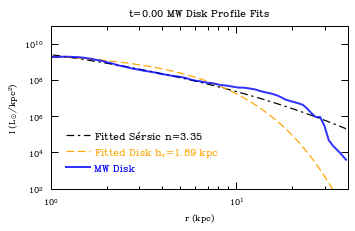

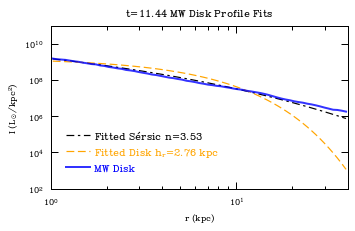

In [79]:
snaps = [0, 801] # first and last

# loop through selected snapshots:
for snap in snaps:
    
    # Set up big plot
    fig = plt.figure(figsize=(16/3, 9/3))
    ax = fig.subplots()

    Gyr = snap * 0.01 / 0.7  # Show the difference at the start of the simulation

    # choose how to fit to the intensity profile
    fit_ops = ['sersic', 'disk']

    # Set the plot limits to something that works for them all
    ax.set(xlim=(10**(0), 0.4*10**(2)), ylim=(10**2, 10**11))

    # Axis labels, axis limits, and plot title
    ax.set(xlabel=r'$r \ (\mathrm{kpc})$',
           ylabel=r'$I \ \left(\mathrm{L_\odot} / \mathrm{kpc}^2\right)$',
           title=r'$t \! = \! {:.2f}$ MW Disk Profile Fits'.format(Gyr))

    # choose galaxy and component
    galaxy = 'MW'
    component = 'Disk'

    
    # add a string of the filenumber to the value “000”
    snap_str= '000' + str(snap)
    # remove all but the last 3 digits
    snap_str = snap_str[-3:]

    for fit_op in fit_ops:

        # Initialize the class
        radial_intensity = RadialIntensity(galaxy, snap, res, component, r_num, fit_op)

        # Get the radii, profile, and equivalent radius for the file used
        # also plots 
        *plot_params ,= radial_intensity.profile()

        r_annuli = plot_params[0]
        I = plot_params[1]
        R_e = plot_params[2]

        # plot and store the Sersic index or scale length in param_arr
        param = radial_intensity.fit(*plot_params, fit_op)

        if fit_op == 'disk':
            print(f'param_disk = {param} kpc')

            # plot the fitted exponential disk
            ax.loglog(r_annuli, disk(r_annuli, param, radial_intensity.m_tot),
                      color='orange', linestyle="--",
                      label=r'Fitted Disk $h_r \! = \! {:.2f} \ kpc$'.format(param))

        elif fit_op == 'sersic':
            param_sersic = param
            print(f'param_sersic = {param_sersic}')

            # plot a Sersic fit
            ax.loglog(r_annuli, sersic(r_annuli, R_e, param, radial_intensity.m_tot),
                      color='k',linestyle="-.",
                      label=r'Fitted Sérsic $n \! = \! {:.2f}$'.format(param))

    # Plot the calculated intensity profile (log-log)
    ax.loglog(r_annuli, I, alpha=0.8, label=galaxy + ' ' + component, lw=2, color=radial_intensity.color)        

    # legend and tidy things up
    ax.legend(loc=3, labelcolor='linecolor', fontsize=12)
    #fig.tight_layout()

    # Save the plot as a PNG
    plt.savefig(f'/Users/gabeweible/Desktop/fit_comp_'+snap_str+'.png', facecolor='w', dpi=600)